In [ ]:
"""
This script is an attempt to see if image decoding is different in A vs not A trials
This is for sure a work in progress: I didn't see any major differences on my first pass.
Created by Yoni Browning, August 2018.
"""

In [4]:
#%load_ext autoreload
#%autoreload 2
import matplotlib as mpl
import scipy as sp
import numpy as np
import pandas as pd
# sometimes order maters on these
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import oBehave.plotting_stuff as obps
import oBehave.helperfunctions as obhf
import oBehave.neural_analysis as obna
import oBehave.behavior_analysis as obba
import sklearn.decomposition as decomp
from sklearn.model_selection import train_test_split
import sklearn.decomposition as decomp
from sklearn.preprocessing import StandardScaler

from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.utilities import get_trace_around_timepoint,get_nearest_frame
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# Load the manifest
manifest = obhf.load_manifest()
obba.includeNovelSession(manifest);

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [84]:
# Loat a single data set
experiment_id = 639438856# experiment B
#experiment_id = 639253368
dataset= VisualBehaviorOphysDataset(experiment_id=experiment_id, cache_dir=obhf.drive_path)
analysis = ResponseAnalysis(dataset)

loading trial response dataframe
loading flash response dataframe


In [35]:
# Define some functions we will need...
# In the long run these should be sent to ob as callable functions
def killnancells(dataset,analysis):
    bad_cell_indices = []
    bad_cell_ids = []
    for cell_index in range(dataset.dff_traces[1].shape[0]):
        if np.isnan(dataset.dff_traces[1][cell_index][0]): #check whether first datapoint is nan
           bad_cell_indices.append(cell_index)
           bad_cell_ids.append(dataset.get_cell_specimen_id_for_cell_index(cell_index))
    fdf = analysis.flash_response_df.copy()
    fdf = fdf[fdf.cell.isin(bad_cell_indices)==False]
    return fdf

def getResponseArray(dataset,analysis):
    # We want to bootstrap dim analysis:
    num_trials = len(dataset.stimulus_table)
    fr = killnancells(dataset,analysis)
    use_cells = np.unique(fr.cell)
    response_array = np.empty((num_trials,len(use_cells)))
    for i in range(num_trials):
        response_array[i,:] = fr[fr.flash_number==i].mean_response.values
    return response_array,fr # return response array and flash response data frame

In [88]:
# fit kNN and linear classifiers to a specific subset of the manifest. Store as a dataframe, with cross val scores.
tmp_manifest = manifest[(manifest.targeted_structure=='VISp')&manifest.cre_line.str.contains('Slc')&(manifest.first_session)]
keylist = ['experiment_id','session_type','donor_id','scores','scores_kNN','performance','performance_kNN']
fitdata = {k:[] for k in keylist}
for ii,row in tmp_manifest.iterrows():
    LDA = LinearDiscriminantAnalysis()
    dataset= VisualBehaviorOphysDataset(experiment_id=row.experiment_id, cache_dir=obhf.drive_path)
    analysis = ResponseAnalysis(dataset) 
    X,fr = getResponseArray(dataset,analysis)
    y = fr.image_name.values[np.unique(fr.flash_number)]
    # split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2, 
        stratify=y, # this makes sure that our training and testing sets both have all classes in y
    )
    scores = cross_val_score(LDA, X_train, y_train, cv=5)

    fitdata['scores'].append(scores)
    fitdata['performance'].append(scores.mean() * len(np.unique(y_train)))
    #fitdata['LDA'].append(LDA)
    
    fitdata['experiment_id'].append(row.experiment_id)
    fitdata['session_type'].append(row.session_type)
    fitdata['donor_id'].append(row.donor_id)
    
    #kNN = KNeighborsClassifier(n_neighbors=10)
    SVM = LinearSVC()
    scores_kNN = cross_val_score(SVM, X_train, y_train, cv=5)
    fitdata['scores_kNN'].append(scores_pca)
    fitdata['performance_kNN'].append(scores_pca.mean() * len(np.unique(y_train)))
    #fitdata['LDA'].append(LDA)
    
    
    print(str(row.experiment_id)+', ' 
          +row.session_type+": "
          +str((scores_kNN.mean() * len(np.unique(y_train)))/(scores.mean() * len(np.unique(y_train)))))

    

loading trial response dataframe
loading flash response dataframe
652844352, behavior_session_A: 1.0756996919411086
loading trial response dataframe
loading flash response dataframe
653053906, behavior_session_C: 1.0344403868955934
loading trial response dataframe


KeyboardInterrupt: 

In [78]:
# confirm outputs for plotting
FitData = pd.DataFrame(fitdata)
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
FitData.head()

,donor_id,experiment_id,performance,performance_pca,scores,scores_pca,session_type
0,333706,652844352,5.035301,3.305314,"[0.6150845253576073, 0.6315104166666666, 0.628...","[0.42002600780234073, 0.40234375, 0.4235294117...",behavior_session_A
1,333706,653053906,4.892414,2.553736,"[0.6223958333333334, 0.6344647519582245, 0.578...","[0.3294270833333333, 0.30809399477806787, 0.31...",behavior_session_C
2,333706,653123781,4.786107,2.585369,"[0.5786736020806242, 0.5801825293350718, 0.619...","[0.305591677503251, 0.3194263363754889, 0.3167...",behavior_session_D
3,334310,639253368,4.733466,3.136772,"[0.5950520833333334, 0.6002604166666666, 0.583...","[0.3919270833333333, 0.41015625, 0.37336814621...",behavior_session_A
4,334310,639438856,7.312197,4.472608,"[0.9311688311688312, 0.9139504563233377, 0.911...","[0.5428571428571428, 0.5580182529335072, 0.546...",behavior_session_B


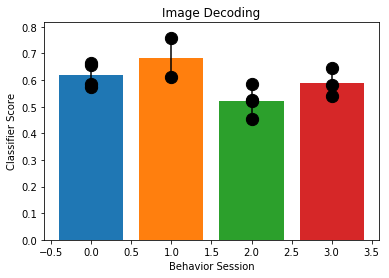

In [80]:
# Ant plot results!! 
behaviors = ['behavior_session_A','behavior_session_B','behavior_session_C','behavior_session_D']
for ii,beh in enumerate(behaviors):
    fd = FitData[FitData.session_type ==beh]
    this_data = fd.performance_pca.values/fd.performance.values
    plt.scatter(ii*np.ones(this_data.shape),this_data,marker='o',s = 150,color = 'k',zorder = 2)
    plt.bar(ii,this_data.mean(),yerr = this_data.std(),color = colorlist[ii])
    plt.xlabel('Behavior Session')
    plt.ylabel('Classifier Score')
    plt.title('Image Decoding')